In [ ]:
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import zipfile
import io
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import os
import time
from datetime import datetime

# see the lab documentation for details of the unet models

%matplotlib inline


## Models

In [ ]:
# RCNN convnet1 
class convnet1(nn.Module):
    def __init__(self, in_ch=3, n_channels=8):
        super(convnet1, self).__init__()
        self.activation = F.relu
        
        self.conv1 = nn.Conv2d(in_ch, n_channels, kernel_size= 1, padding=0)
        self.conv2 = nn.Conv2d(n_channels, 1, kernel_size= 1, padding=0)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        
        return out
    
## Unet1
class unet1(nn.Module):
    def __init__(self, in_ch=3, n_channels=8):
        super(unet1, self).__init__()
        self.activation = F.relu
        
        self.down1 = down_block(in_ch, n_channels)

        self.bridge = down_block(in_ch=n_channels, out_ch=n_channels*2, max_pooling=False)

        self.up1 = up_block(in_ch=n_channels*2, out_ch=n_channels)
        self.final_conv = nn.Conv2d(n_channels, 1, kernel_size= 1, padding=0)
    
    def forward(self, x):
        out, skip1 = self.down1(x)
        out, _ = self.bridge(out)
        
        out = self.up1(out, skip1)
        out = self.final_conv(out)
        
        return out

## Unet2
class unet2(nn.Module):
    def __init__(self, in_ch=3, n_channels=8):
        super(unet2, self).__init__()
        
        self.down1 = down_block(in_ch, n_channels)
        self.down2 = down_block(in_ch=n_channels, out_ch=n_channels*2)

        self.bridge= down_block(in_ch=n_channels*2, out_ch=n_channels*4, max_pooling=False)

        self.up1 = up_block(in_ch=n_channels*4, out_ch=n_channels*2)
        self.up2 = up_block(in_ch=n_channels*2, out_ch=n_channels)
        self.final_conv = nn.Conv2d(n_channels, 1, kernel_size= 1, padding=0)
    
    def forward(self, x):
        out, skip1 = self.down1(x)
        out, skip2 = self.down2(out)

        out, _ = self.bridge(out)

        out = self.up1(out, skip2)
        out = self.up2(out, skip1)
        out = self.final_conv(out)
        
        return out
    
    
class down_block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dropout_prob=0, max_pooling=True):
        super(down_block, self).__init__()
        
        self.dropout_prob = dropout_prob
        self.max_pooling = max_pooling
        
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.activation = F.relu
        
        # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
        if dropout_prob > 0:
            self.dropout = nn.Dropout2d(p=dropout_prob)

        # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
        if max_pooling:
            self.maxpool = nn.MaxPool2d(2)

    def forward(self, inputs):
        conv = self.conv(inputs)
        conv = self.bn(conv)
        conv = self.activation(conv)
        
        if self.dropout_prob > 0:
            conv = self.dropout(conv)
            
        next_layer = conv
        skip_connection = conv
        
        if self.max_pooling:
            next_layer = self.maxpool(conv)
        
        return next_layer, skip_connection
   
class up_block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3):
        super(up_block, self).__init__()
        
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.activation = F.relu
        
    def forward(self, expansive_input, contractive_input=None):
        up = self.up(expansive_input)
        
        merge = torch.cat([up, contractive_input], axis=1)
        
        out = self.conv(merge)
        out = self.bn(out)
        out = self.activation(out)
        return out   

## Custom Dataset

In [ ]:
# utility function to display input image and its segmentation side by side
def display_images(label, input_img, seg_img, pred_img=None):
    # input_img = channels x width x height array
    # seg_img = 1 x width x height array
    # pred_img = 1 x width x height array (optional)
    
    input_img = np.moveaxis(input_img, 0, -1)
    seg_img = np.squeeze(seg_img)
    
    if pred_img is None:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes[0].imshow(input_img)
    axes[0].set_title('Input')
    axes[1].imshow(seg_img, cmap='gray')
    axes[1].set_title('Target')
    
    if pred_img is not None:
        pred_img = np.squeeze(pred_img)
        axes[2].imshow(pred_img, cmap='gray')
        axes[2].set_title('Prediction')
    fig.suptitle(label)

    
class SegmentationDataset():
    """
    img_dir = directory containing images
    labels = list of image labels
    """
    def __init__(self, img_dir, labels):
        self.img_dir = img_dir
        self.labels  = labels
        
    def __getitem__(self, index):
        label = self.labels[index]
        img_id = label.split(".")[0][2:]
        input_img_label = "im%s.png" % img_id
        seg_img_label = "imseg%s.png" % img_id
        input_img_path = os.path.join(self.img_dir, input_img_label)
        seg_img_path = os.path.join(self.img_dir, seg_img_label)
        
        input_img = np.asarray(imageio.imread(input_img_path))
        seg_img = np.asarray(imageio.imread(seg_img_path))

        input_img = input_img / 255.0
        input_img = np.moveaxis(input_img, -1, 0)
        seg_img = seg_img / 255
        seg_img = np.expand_dims(seg_img, axis=0)

        return label, input_img, seg_img
    
    def __len__(self):
        return len(self.labels)


## Download and Initialize the custom datasets

In [ ]:
# If on JHUB use local dataset else download
JHUB = 0

#select the dataset
#
# 16 x 16 color digits
#dsetn = "lab9data1"
# 16 x 16 red digits
#dsetn = "lab9data1r"
# 16 x 16 red digits
#dsetn = "lab9data2"
# 16 x 16 red digits
#dsetn = "lab9data2r"
# 64 x 64 images with color digits
dsetn = "lab9data3"
# 64 x 64 images with red digits
#dsetn = "lab9data3r"

## On JHUB use downloaded dataet
if  JHUB:
   dset = "/classes/ece5470/lab/lab9/" + dsetn
else:
    dset = dsetn
    url = 'https://www.via.cornell.edu/ece5470/' + dsetn + '.zip'
    r = requests.get(url).content
    z = zipfile.ZipFile(io.BytesIO(r))
    z.extractall('./' + dset)

labels_df = pd.read_csv(os.path.join(dset, "labels.csv"))
labels = labels_df.iloc[:, 0].values

print("Total number of images:", len(labels))

test_labels = labels[:100]
val_labels = labels[100:200]
#train_labels = labels[200:]
train_labels = labels[200:700]


Total number of images: 1000


In [ ]:
# Load Images
train_dataset = SegmentationDataset(dset, train_labels)
val_dataset   = SegmentationDataset(dset, val_labels)
test_dataset  = SegmentationDataset(dset, test_labels)


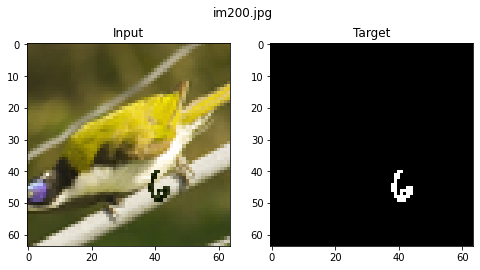

In [ ]:
# show example input image/segmentation pairs
elist = iter(train_dataset)
for idx in range(1):
    label, input_img, target = next(elist)   
    display_images(label, input_img, target)


# Training and Evaluation functions

In [ ]:
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    avg_loss = 0

    for batch_idx, (label, data, target) in enumerate(train_loader):
        data = data.float()
        target = target.float()
        
        optimizer.zero_grad()
        output = model(data)

        loss = loss_fn(output, target)

        loss.backward()
        optimizer.step()
        avg_loss += (loss.item() * data.size(0) / len(train_loader.sampler))

        if batch_idx % 10 == 0 and batch_idx > 0:
            print('  [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return avg_loss

def eval(model, val_loader, loss_fn):
    model.eval()
    avg_loss = 0

    with torch.no_grad():
        for batch_idx, (label, data, target) in enumerate(val_loader):
            data = data.float()
            target = target.float()

            output = model(data)

            loss = loss_fn(output, target)

            avg_loss += (loss.item() * data.size(0) / len(val_loader.sampler))

    return avg_loss

In [ ]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

## Main


In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

""" initialization """
model = convnet1()
optimizer = optim. Adam(model.parameters(), lr=LEARNING_RATE)

# loss_fn = FocalLoss()
# loss_fn = DiceLoss()
loss_fn =  nn.BCEWithLogitsLoss()

""" cooking """
train_losses = []
val_losses = []
best_val_loss = np.inf

start_time = datetime.now()
for epoch in range(NUM_EPOCHS):
    print("------- Epoch", epoch+1, "-------")
    print("  Training")
    train_loss = train(model, train_loader, optimizer, loss_fn)
    print("     Loss =", train_loss)
    print("  Validation")
    val_loss   = eval(model, val_loader, loss_fn)
    print("     Loss =", val_loss)

    val_losses.append(val_loss)
    train_losses.append(train_loss)
    
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), "best_model.pth") # remember to change the filename if you don't want to overwrite the saved checkpoint
        best_val_loss = val_loss
print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

------- Epoch 1 -------
  Training
  [160/500 (31%)] Loss: 0.457511
  [320/500 (62%)] Loss: 0.344287
  [480/500 (94%)] Loss: 0.221582
     Loss = 0.4000990211963653
  Validation
     Loss = 0.1966332978010178
------- Epoch 2 -------
  Training
  [160/500 (31%)] Loss: 0.119978
  [320/500 (62%)] Loss: 0.091539
  [480/500 (94%)] Loss: 0.070447
     Loss = 0.11544453859329225
  Validation
     Loss = 0.0773755368590355
------- Epoch 3 -------
  Training
  [160/500 (31%)] Loss: 0.061790
  [320/500 (62%)] Loss: 0.065278
  [480/500 (94%)] Loss: 0.061940
     Loss = 0.06926073816418647
  Validation
     Loss = 0.06900543645024299
------- Epoch 4 -------
  Training
  [160/500 (31%)] Loss: 0.073938
  [320/500 (62%)] Loss: 0.070269
  [480/500 (94%)] Loss: 0.067399
     Loss = 0.06548584589362146
  Validation
     Loss = 0.06738502040505408
------- Epoch 5 -------
  Training
  [160/500 (31%)] Loss: 0.066784
  [320/500 (62%)] Loss: 0.061258
  [480/500 (94%)] Loss: 0.061025
     Loss = 0.06416819047

# Evaluation

In [ ]:
def plot_loss_curves(train_losses, val_losses):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    ax.plot(train_losses)
    ax.plot(val_losses)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'])

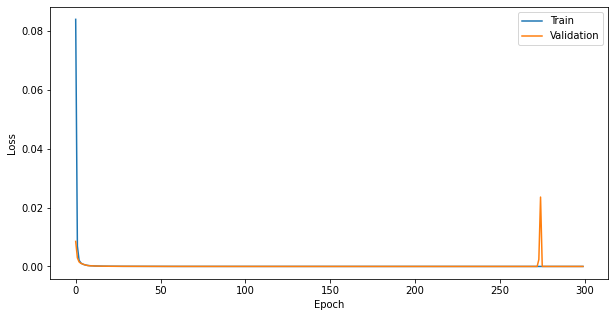

In [ ]:
plot_loss_curves(train_losses, val_losses)

In [ ]:
def compute_dice_score(im1, im2):
    # compute Dice score between 2 binary images im1 and im2
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape")

    denom = im1.sum() + im2.sum()
    if denom == 0:
        return None

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / denom


In [ ]:
def predict(model, test_loader, threshold=0.5):
    model.eval()

    pred = []
    with torch.no_grad():
        for batch_idx, (label, data, target) in enumerate(test_loader):
            data = data.float()
            target = target.float()

            output = torch.sigmoid(model(data))
            output[output >= threshold] = 1 # binarize the prediction at threshold
            output[output < threshold] = 0
            
            for i in range(target.shape[0]):
                sample_label = label[i]
                sample_data = data[i, :, :, :]
                sample_target = target[i, :, :, :]
                sample_pred = output[i, :, : , :]
                
                dice = compute_dice_score(sample_target, sample_pred)
            
                pred.append({
                    "label": sample_label,
                    "input": sample_data.numpy(),
                    "target": sample_target.numpy(),
                    "pred": sample_pred.numpy(),
                    "dice": dice
                })
    return pred


In [ ]:
test_loader   = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

start_time = datetime.now()
pred = predict(model, test_loader, threshold=0.05)
print("Average Dice score =", np.mean([sample["dice"] for sample in pred]))
print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

Average Dice score = 0.6377071236263536
Time Elapsed: 0.13244 seconds


<ipython-input-54-ddfd8576663a>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
<ipython-input-54-ddfd8576663a>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)


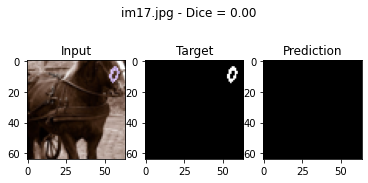

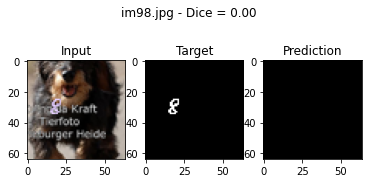

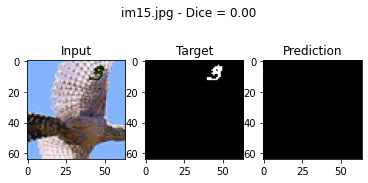

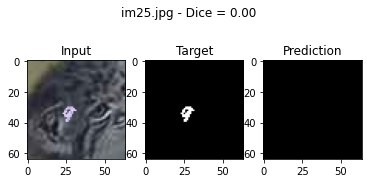

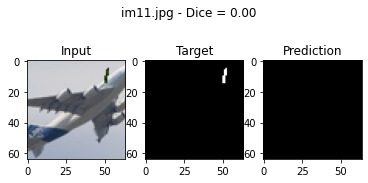

In [ ]:
# show example results

for idx in range(5):
    random_sample = np.random.choice(pred)
    display_images("%s - Dice = %.2f" % (random_sample["label"], random_sample["dice"]), random_sample["input"], random_sample["target"], random_sample["pred"])


<ipython-input-54-ddfd8576663a>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
<ipython-input-54-ddfd8576663a>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)


Average Dice score for threshold 0.05 = 0.8535334807633299
Time Elapsed: 0.298195 seconds
Average Dice score for threshold 0.025 = 0.7457871804317112
Time Elapsed: 0.576879 seconds
Average Dice score for threshold 0.05 = 0.8535334807633299
Time Elapsed: 0.847648 seconds
Average Dice score for threshold 0.07 = 0.8897380031247438
Time Elapsed: 1.102807 seconds
Average Dice score for threshold 0.08 = 0.902834859490272
Time Elapsed: 1.352909 seconds
Average Dice score for threshold 0.1 = 0.9207333507484049
Time Elapsed: 1.615694 seconds
Average Dice score for threshold 0.12 = 0.9325073198193066
Time Elapsed: 1.87225 seconds
Average Dice score for threshold 0.3 = 0.96358527074533
Time Elapsed: 2.139569 seconds
Average Dice score for threshold 0.5 = 0.9649411135582677
Time Elapsed: 2.408474 seconds


Text(0.5, 0, 'Threshold')

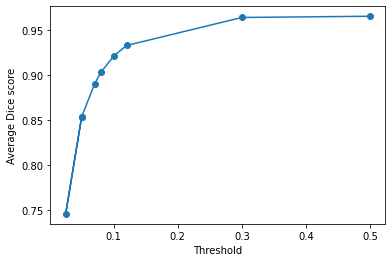

In [ ]:
test_loader   = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

x=[0.025,0.05, 0.07, 0.08,0.1, 0.12, 0.3, 0.5]     #x is the set of threshold values. You can modify it.
y=[]
start_time = datetime.now()
for i in x:
    pred = predict(model, test_loader, threshold=i)
    mp=np.mean([sample["dice"] for sample in pred])
    print("Average Dice score for threshold",i, "=",mp)
    print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))
    y.append(mp)

#plotting Average Dice score based on given thrshold values
fig, ax = plt.subplots()
ax.plot(x,y,'-o')
ax.set_ylabel('Average Dice score')
ax.set_xlabel('Threshold')